In [1]:
import os
import cases

import matplotlib.pyplot as plt

from buildingspy.io.outputfile import Reader
from buildingspy.io.postprocess import Plotter

In [ ]:
print cases


In [ ]:
cases.get_case('annual_base')

In [6]:
# Read data
resultFile = cases.get_result_file_name('annual_base')
r_base_annual=Reader(resultFile, "dymola")



**** ASHRAE2006


Plot room temperatures

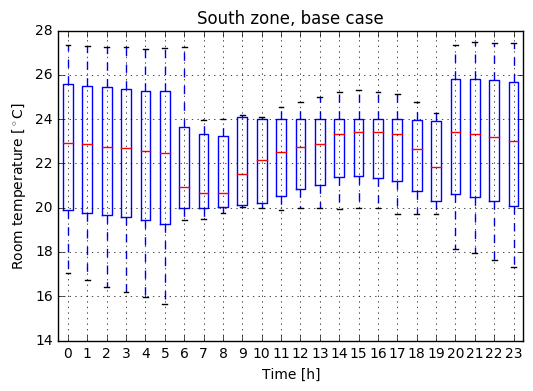

In [8]:
(t, y) = r.values('flo.sou.air.vol.T')
plt=Plotter.boxplot(t=t, y=y-273.15, increment=3600, nIncrement=24)

# Decorate, save and show the plot
plt.xlabel('Time [h]') 
plt.ylabel(u'Room temperature [$^\circ$C]') 
plt.grid()
plt.savefig("roomTemperatures.png")
plt.savefig("roomTemperatures.pdf")
plt.title('South zone, base case')
plt.show() 

# # Energy use

In [ ]:
objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()